In [1]:
# basic dependencies

import numpy as np
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

In [3]:
# botorch dependencies

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.gp_regression_mixed import MixedSingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list, optimize_acqf_mixed
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# rest of the training loop
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

# Sam's work on ref point inferrence & feasibility weighing
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from botorch.acquisition.multi_objective.objective import MCMultiOutputObjective
from botorch.acquisition.utils import get_infeasible_cost
from typing import Optional
from torch import Tensor
from botorch.utils import apply_constraints

# argument for adding feasiility weighting to outcomes
class GenericMCMultiOutputObjective(GenericMCObjective, MCMultiOutputObjective):
    pass

# others
from botorch.exceptions import BadInitialCandidatesWarning
import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
def optimize_sobol(problem, ref_point, N_BATCH, initial_x,
                   BATCH_SIZE=2,NUM_RESTARTS=20,RAW_SAMPLES=1024,
                   random_state=torch.randint(1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with Sobol")
    
    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    ##########
    
    # original location for an extra HV check wrt to initial samples
    
    ##########

    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
        
        ##########

        # get new random observations for sobol
        new_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=BATCH_SIZE, seed=torch.randint(1000000, (1,)).item()).squeeze(0)
        new_obj, new_con = problem.evaluate(new_x)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        
        # calculate hypervolume based on checks, done on noiseless train_obj and train_con
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)
        
        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        ########## end of iteration loop
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:  
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
        
    # returns the HV score across iterations, total training set as an array, plus list of feasible candidates
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

In [5]:
def optimize_qnehvi(problem, ref_point, N_BATCH, initial_x, # must haves
                    BATCH_SIZE=2, custom_batch=None, # you can pick between standard batching or custom tapered
                    feas_weighing=False, eta_relax=False, # options for weighting, and constraint relaxation
                    NUM_RESTARTS=20,RAW_SAMPLES=1024,
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    ##########
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop

    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
        
        ##########
        
        # fit the surrogate model
        fit_gpytorch_model(mll)
        
        ##########
        
        # option for relaxation of constraint sigmoid approximation
        
        if eta_relax is True:
        # value of eta for applying constraints via sigmoid approximation
        # starts as eta=1 (closely approximates constraints) and slowly relaxes to 0.001
            eta_range = np.flip(np.arange(0.001, 1.001, (1 - 0.001)/(N_BATCH-1)))
            eta = eta_range[iteration-1]
        else:
            eta = 0.001 # you can change the default here, TODO: input in the function definition
        
        ##########
        
        # option for changing from EIC to feasibility weighted outcomes
        if feas_weighing is True:
                        
            # arguments for defining a feasibility weighted objective wrt to the problem
            infeasible_cost = get_infeasible_cost(X=train_x,
                                                  model=model,
                                                  objective=lambda y: y[..., :problem.n_obj])

            # treat the first n_obj worth of n_constr as feasibility weighting on objectives
            def feasibility_constraint_callable(Z): 
                return Z[..., problem.n_obj:problem.n_obj+problem.n_obj]

            # take leftover n_constr as direct constraints on expected improvement
            def improvement_constraint_callable(Z): 
                    return Z[..., problem.n_obj+problem.n_obj]
            if problem.n_constr>problem.n_obj:
                constraint_argument = [improvement_constraint_callable]
            else: # if n_constr<=n_obj, improvement constraints won't trigger
                constraint_argument = None

            # func to define the weighted objectives on BoTorch's objective class
            def apply_feasibility_weights(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
                return apply_constraints(obj=Y[..., :problem.n_obj],
                                         constraints=[feasibility_constraint_callable],
                                         samples=Y,
                                         infeasible_cost=infeasible_cost,
                                         eta=eta)
            objective = GenericMCMultiOutputObjective(apply_feasibility_weights)

            # define the acqusition function
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=-ref_point, # for computing HV, must flip for BoTorch
                X_baseline=train_x, # feed total list of train_x for this current iteration
                sampler=SobolQMCNormalSampler(num_samples=128), # determines how candidates are randomly proposed before selection
                objective=objective,
                constraints=constraint_argument,
                prune_baseline=True, cache_pending=True) # options for improving qNEHVI, keep these on
            
        else:
            # define the acqusition function for EIC if feas_weighting is false
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=-ref_point, # for computing HV, must flip for BoTorch
                X_baseline=train_x, # feed total list of train_x for this current iteration
                sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
                objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
                constraints=[lambda Z: Z[...,-x] for x in range(problem.n_constr)], # constraint on last n_constr col
                eta=eta,
                prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # option for tapering BATCH_SIZE
        if custom_batch is not None:
            curr_batch_size = batch_list[iteration-1]
            
        else:
            curr_batch_size = BATCH_SIZE # otherwise takes the BATCH_SIZE argument
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=curr_batch_size, # no of candidates to propose in parallel
                        num_restarts=NUM_RESTARTS, # no of restarts if q candidates fail to show improvement
                        raw_samples=RAW_SAMPLES,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        equality_constraints=problem.equality_constr, # seperate argument for equality constraints, not verified yet   
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        model = SingleTaskGP(train_x_gp, train_y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
        
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
    
    # returns the HV score across iterations, total training set as an array, plus list of feasible candidates
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

In [6]:
# pymoo dependencies
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.optimize import minimize

from pymoo.interface import sample
from pymoo.visualization.scatter import Scatter

In [7]:
def optimize_nsga3(problem, ref_point, N_BATCH, initial_x, # must haves
                   pop_size=100, ref_num=10, # as a rule of thumb, pop_size>ref_num,
                   noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             n_constr=problem.n_constr,
                             xl=Problem.bounds[0].cpu().numpy(),
                             xu=Problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj, train_con = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
            train_con_noisy = train_con + noise*torch.randn_like(train_con)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            out["G"] = train_con_noisy.cpu().numpy()
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = NSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")

    ##########
        
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    for i in range(0,N_BATCH):
        train_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        train_obj, train_con = problem.evaluate(train_x)

        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj, train_con = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj, new_con = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
        
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

In [8]:
class ProblemBase(torch.nn.Module):   
    def g3(X, n_obj):
        contrib = 2.0 * torch.pow(
            X[:, n_obj - 1:] + (X[:, n_obj - 2:-1] - 0.5) * (X[:, n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def LA1(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * np.pi * torch.pow(theta, C)), D)

    def LA2(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * torch.pow(theta, C)), D)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 4
    n_obj = 2
    n_constr = 2 # inequality constraints only!
    
    equality_constr = None # leave as None for now, TODO in future
    
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(4, **tkwargs),torch.ones(4, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = ProblemBase.g3(X, n_obj=2)
        f1 = g * X[:, 0]
        f2 = g * torch.sqrt(1.0 - torch.pow(f1 / g, 2.0))
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        # if no constraints, write as c1 = 0 * X[..., 0], and set n_constr=1     
        atan = torch.arctan(f2 / f1)
        c1 = f1 ** 2 + f2 ** 2 - torch.pow(1.2 + torch.abs(ProblemBase.LA2(0.4, 4.0, 1.0, 16.0, atan)), 2.0)
        c2 = torch.pow(1.15 - ProblemBase.LA2(0.2, 4.0, 1.0, 8.0, atan), 2.0) - f1 ** 2 - f2 ** 2
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2], dim=-1)
        
        return output, slack
    
assert Problem.n_obj == Problem.evaluate(torch.ones(1, Problem.n_var, **tkwargs))[0].size(dim=-1),"Number of objectives and n_obj should match!"
assert Problem.n_var == Problem.bounds.size(dim=1),"Number of variables and bounds should match!"
assert Problem.n_constr == Problem.evaluate(torch.ones(1, Problem.n_var, **tkwargs))[1].size(dim=-1), "Number of constraints and n_constr should match!"

In [9]:
# example of adding custom batching for tapering
np.concatenate((np.repeat(8, 15),
                np.repeat(4, 15),
                np.repeat(2, 10),
                ))

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [10]:
# basic arguments
noise = 0
verbose = True
ref_point = torch.tensor([1.1,1.1], **tkwargs)

N_TRIALS = 2
N_BATCH = 25
BATCH_SIZE = 4

# overall list to append multiple N_TRIAL runs
hvs_sobol_all, train_sobol_all, candidates_sobol_all = [], [], []
hvs_qnehvi_all, train_qnehvi_all, candidates_qnehvi_all = [], [], []
hvs_nsga3_all, train_nsga3_all, candidates_nsga3_all = [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS}\n", end="")
    
    # initialize with a 2*(d+1) sample set
    initial_x = draw_sobol_samples(bounds=Problem.bounds,n=1, q=2*(Problem.n_var+1), seed=trial).squeeze(0)
    
    ###############    
    
    hvs_sobol, train_sobol, candidates_sobol = optimize_sobol(
                                                        Problem, ref_point, N_BATCH, initial_x,
                                                        BATCH_SIZE=BATCH_SIZE,
                                                        random_state=trial, verbose=verbose)
    hvs_sobol_all.append(hvs_sobol)
    train_sobol_all.append(train_sobol)
    candidates_sobol_all.append(candidates_sobol)  
    
    ###############
    
    hvs_qnehvi, train_qnehvi, candidates_qnehvi = optimize_qnehvi(
                                                        Problem, ref_point, N_BATCH, initial_x,
                                                        BATCH_SIZE=BATCH_SIZE, custom_batch=None,
                                                        feas_weighing=False, eta_relax=True,
                                                        random_state=trial, noise=noise, verbose=verbose)
    hvs_qnehvi_all.append(hvs_qnehvi)
    train_qnehvi_all.append(train_qnehvi)
    candidates_qnehvi_all.append(candidates_qnehvi)
    
    ###############
    
    hvs_nsga3, train_nsga3, candidates_nsga3 = optimize_nsga3(
                                                        Problem, ref_point, N_BATCH, initial_x,
                                                        pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                        random_state=trial, noise=noise, verbose=verbose)
    hvs_nsga3_all.append(hvs_nsga3)
    train_nsga3_all.append(train_nsga3)
    candidates_nsga3_all.append(candidates_nsga3)


Trial  1 of 2
Optimizing with Sobol
Batch  1 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  2 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  3 of 25: Hypervolume = 0.00, time = 0.01s.
Batch  4 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  5 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  6 of 25: Hypervolume = 0.00, time = 0.01s.
Batch  7 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  8 of 25: Hypervolume = 0.00, time = 0.00s.
Batch  9 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 10 of 25: Hypervolume = 0.00, time = 0.01s.
Batch 11 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 12 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 13 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 14 of 25: Hypervolume = 0.00, time = 0.01s.
Batch 15 of 25: Hypervolume = 0.00, time = 0.01s.
Batch 16 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 17 of 25: Hypervolume = 0.00, time = 0.00s.
Batch 18 of 25: Hypervolume = 0.11, time = 0.01s.
Batch 19 of 25: Hypervolume = 0.11, time = 0.00s.
Batch 20 of 2

DONE!



In [11]:
# plotting dependencies
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

max_hv = 0.2920464702006572 # previously found by brute forcing NSGA-III

Text(0.5, 1.0, 'ZDT1 (d=4)')

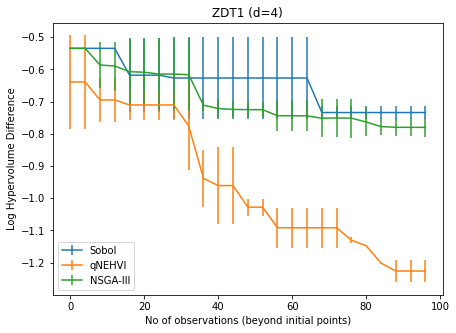

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# convert hvs into log hypvervolume difference
hv_sobol_plot = np.log10(max_hv - np.asarray(hvs_sobol_all)) 
hv_qnehvi_plot = np.log10(max_hv - np.asarray(hvs_qnehvi_all)) 
hv_nsga3_plot = np.log10(max_hv - np.asarray(hvs_nsga3_all)) 

observations = np.arange(N_BATCH)*BATCH_SIZE
# for custom batching put np.concatenate((np.zeros(1), np.cumsum(batch_list)[:-1]))

ax.errorbar(observations,
            hv_sobol_plot.mean(axis=0),
            yerr=ci(hv_sobol_plot, N_TRIALS),
            label="Sobol", linewidth=1.5,)
ax.errorbar(observations,
            hv_qnehvi_plot.mean(axis=0),
            yerr=ci(hv_qnehvi_plot, N_TRIALS),
            label="qNEHVI", linewidth=1.5,)
ax.errorbar(observations,
            hv_nsga3_plot.mean(axis=0),
            yerr=ci(hv_nsga3_plot, N_TRIALS),
            label="NSGA-III", linewidth=1.5,)

ax.set(xlabel='No of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")
ax.set_title("ZDT1 (d=4)")

Text(0.5, 1.0, 'ZDT1 (d=4)')

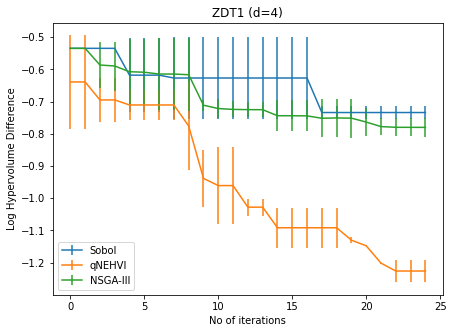

In [13]:
# plot in terms of observations instead

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

iters = np.arange(N_BATCH)
# for custom batching, put np.arange(len(batch_list))

ax.errorbar(iters,
            hv_sobol_plot.mean(axis=0),
            yerr=ci(hv_sobol_plot, N_TRIALS),
            label="Sobol", linewidth=1.5,)
ax.errorbar(iters,
            hv_qnehvi_plot.mean(axis=0),
            yerr=ci(hv_qnehvi_plot, N_TRIALS),
            label="qNEHVI", linewidth=1.5,)
ax.errorbar(iters,
            hv_nsga3_plot.mean(axis=0),
            yerr=ci(hv_nsga3_plot, N_TRIALS),
            label="NSGA-III", linewidth=1.5,)

ax.set(xlabel='No of iterations', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")
ax.set_title("ZDT1 (d=4)")

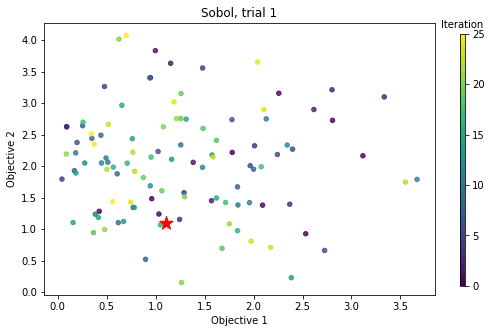

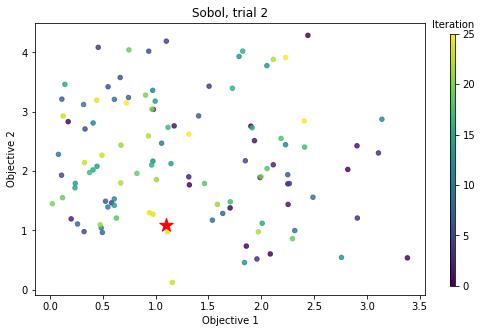

In [14]:
batch_number = torch.cat([torch.zeros(2*(Problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()
# for custom batching, add terms of torch.arange accordingly, make sure 1, N_BATCH+1 is sequential, e.g. (1, 15+1) and (16, 30+1)

for i in range(0, N_TRIALS):
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))

    # don't forget to flip back negative if you done so in Problem class definition!
    axes.scatter(-train_sobol_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,0],
                 -train_sobol_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,1],
                 c=batch_number, s=20, alpha=0.8)

    axes.scatter(ref_point.cpu().numpy()[0], ref_point.cpu().numpy()[1], c="r", s=200, marker="*")

    axes.set_title(f"Sobol, trial {i+1}")
    axes.set_xlabel("Objective 1")
    axes.set_ylabel("Objective 2")
    #axes[i].set_xlim(obj1min, obj1max)
    #axes[i].set_ylim(obj2min, obj2max)

    norm = plt.Normalize(batch_number.min(), batch_number.max())
    sm =  ScalarMappable(norm=norm, cmap=cm)
    sm.set_array([])
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.set_title("Iteration", fontsize=10)

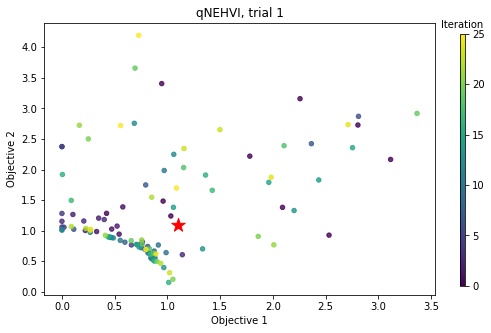

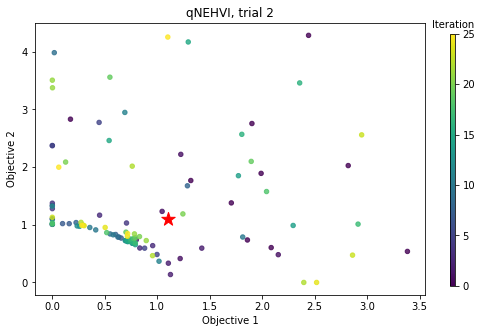

In [15]:
batch_number = torch.cat([torch.zeros(2*(Problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()
# for custom batching, add terms of torch.arange accordingly, make sure 1, N_BATCH+1 is sequential, e.g. (1, 15+1) and (16, 30+1)


for i in range(0, N_TRIALS):
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))

    # don't forget to flip back negative if you done so in Problem class definition!
    axes.scatter(-train_qnehvi_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,0],
                 -train_qnehvi_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,1],
                 c=batch_number, s=20, alpha=0.8)

    axes.scatter(ref_point.cpu().numpy()[0], ref_point.cpu().numpy()[1], c="r", s=200, marker="*")

    axes.set_title(f"qNEHVI, trial {i+1}")
    axes.set_xlabel("Objective 1")
    axes.set_ylabel("Objective 2")
    #axes[i].set_xlim(obj1min, obj1max)
    #axes[i].set_ylim(obj2min, obj2max)

    norm = plt.Normalize(batch_number.min(), batch_number.max())
    sm =  ScalarMappable(norm=norm, cmap=cm)
    sm.set_array([])
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.set_title("Iteration", fontsize=10)

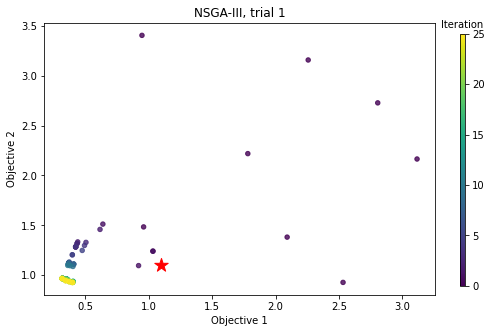

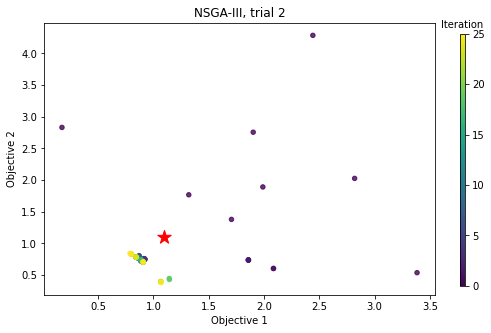

In [16]:
batch_number = torch.cat([torch.zeros(2*(Problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()
# for custom batching, add terms of torch.arange accordingly, make sure 1, N_BATCH+1 is sequential, e.g. (1, 15+1) and (16, 30+1)


for i in range(0, N_TRIALS):
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))

    # don't forget to flip back negative if you done so in Problem class definition!
    axes.scatter(-train_nsga3_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,0],
                 -train_nsga3_all[i][...,(Problem.n_var,Problem.n_var+Problem.n_obj-1)][...,1],
                 c=batch_number, s=20, alpha=0.8)

    axes.scatter(ref_point.cpu().numpy()[0], ref_point.cpu().numpy()[1], c="r", s=200, marker="*")

    axes.set_title(f"NSGA-III, trial {i+1}")
    axes.set_xlabel("Objective 1")
    axes.set_ylabel("Objective 2")
    #axes[i].set_xlim(obj1min, obj1max)
    #axes[i].set_ylim(obj2min, obj2max)

    norm = plt.Normalize(batch_number.min(), batch_number.max())
    sm =  ScalarMappable(norm=norm, cmap=cm)
    sm.set_array([])
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.set_title("Iteration", fontsize=10)

In [18]:
# we take only candidates from qnehvi and nsga3 since they're the best performing ones

algos = ["qNEHVI","NSGA3"]

for i, candidates in enumerate((candidates_qnehvi_all, candidates_nsga3_all)):
    print(f"For algorithm {algos[i]}, the following feasible candidates are:")
    for j in range(0, N_TRIALS):
        for k in range(0, len(candidates[j])):
            print(f"{candidates[j][k][0:Problem.n_var]}"
                  f" --> {-candidates[j][k][Problem.n_var:]}" 
                    # don't forget to flip back negative if you done so in Problem class definition!
                 )
        print("\n")

For algorithm qNEHVI, the following feasible candidates are:
[0.313 0.982 0.721 0.535] --> [0.423 1.284]
[0.316 0.873 0.961 0.755] --> [0.329 0.986]
[0.418 0.982 0.612 0.786] --> [0.472 1.027]
[0.384 1.000 0.936 0.344] --> [0.577 1.389]
[0.498 1.000 0.934 0.710] --> [0.542 0.944]
[0.277 1.000 1.000 1.000] --> [0.348 1.206]
[0.437 0.861 1.000 1.000] --> [0.523 1.075]
[0.883 1.000 1.000 1.000] --> [1.142 0.607]
[0.321 0.773 0.632 1.000] --> [0.401 1.182]
[0.176 0.697 0.748 1.000] --> [0.207 1.158]
[0.000 0.614 0.992 1.000] --> [0.000 1.154]
[0.839 0.733 1.000 1.000] --> [0.987 0.642]
[0.766 0.758 1.000 1.000] --> [0.914 0.766]
[0.925 0.963 0.799 0.875] --> [0.966 0.397]
[0.437 1.000 0.737 0.924] --> [0.437 0.901]
[0.406 1.000 0.693 0.912] --> [0.411 0.925]
[0.895 0.964 0.878 0.864] --> [0.937 0.467]
[0.956 0.957 0.869 0.877] --> [1.020 0.313]


[0.947 0.936 1.000 0.452] --> [1.218 0.415]
[0.923 0.364 1.000 1.000] --> [1.425 0.595]
[0.957 0.837 1.000 1.000] --> [1.106 0.334]
[0.832 1.000 